In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

In [10]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb


Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


In [12]:
#We know that gdp is not stationary, so we will take the first difference
gdp['Value_diff'] = gdp['Value'].diff().fillna(0)

#Using the period 1990-2015 for training and 2016-2020 for testing
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]

gdp_test = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

#Printing the length of the training and testing data
print("gdp lenght: ", len(gdp_train))
print("gdp lenght: ", len(gdp_test))

gdp lenght:  104
gdp lenght:  16


In [13]:
#Creating quarterly dummies
quarters = pd.date_range(start='1990-01-01', end='2019-12-31', freq='Q')
quarter_dummies = pd.get_dummies(quarters.quarter, prefix='Quarter')

# Convert the dummies from boolean values to integer
quarter_dummies = quarter_dummies.astype(int)

In [14]:
# Creating quarterly dummies for the training data
quarter_dummies_train = quarter_dummies.head(len(gdp_train)).copy()

#Creating quarterly dummies for the testing data
quarter_dummies_test = quarter_dummies.tail(len(gdp_test)).copy()

# Extract the target variable
endog_train = gdp_train['Value_diff'] #The differentiated values are used in the training
endog_test = gdp_test['Value'] #The original values are used in the testing

# Extract the actual values for the target variable
endog_train_actuals = gdp_train['Value']
endog_test_actuals = gdp_test['Value']

# Reshape input data for RNN
quarter_dummies_train_reshaped = quarter_dummies_train.values.reshape(quarter_dummies_train.shape[0], quarter_dummies_train.shape[1], 1)
quarter_dummies_test_reshaped = quarter_dummies_test.values.reshape(quarter_dummies_test.shape[0], quarter_dummies_test.shape[1], 1)

# Define the RNN model
model = Sequential([
    SimpleRNN(units=50, activation='tanh', input_shape=(quarter_dummies_train_reshaped.shape[1], quarter_dummies_train_reshaped.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Initialize the list to store the predictions
y_preds = []

# Train the model and predict one step ahead for each observation in the test set
for i in range(len(quarter_dummies_test_reshaped)):
       
    # Train the model on both train and test data up until the current period
    train_exog = np.concatenate((quarter_dummies_train_reshaped, quarter_dummies_test_reshaped[:i]), axis=0)
    train_endog = pd.concat([endog_train, endog_test.iloc[:i]], axis=0)
    norm_endog = pd.concat([endog_train_actuals, endog_test_actuals.iloc[:i]], axis=0)
    
    # Train the model only on historical data up to the current iteration
    model.fit(train_exog, train_endog, epochs=1, batch_size=32, verbose=0)
    
    # Predict one step ahead
    y_pred = model.predict(quarter_dummies_test_reshaped[[i]])

    # Normalize the prediction back to the original scale
    y_pred = y_pred + norm_endog.iloc[-1]

    #Append the prediction to the list
    y_preds.append(y_pred)

# Convert the list of predictions to a numpy array
y_preds = np.array(y_preds)

#Removing the extra dimension
# Reshape predictions back to 2D array
y_preds = np.squeeze(y_preds)

# Calculating the RMSE
rmse_value = rmse(endog_test_actuals, y_preds)
# Calculating the MAPE
mape_value = mean_absolute_percentage_error(endog_test_actuals, y_preds)*100 #Multiplying by 100 to get the percentage

print("The RMSE of the model is:", rmse_value)
print("The MAPE of the model is:", mape_value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The RMSE of the model is: 22.24458250704199
The MAPE of the model is: 3.84775894258612


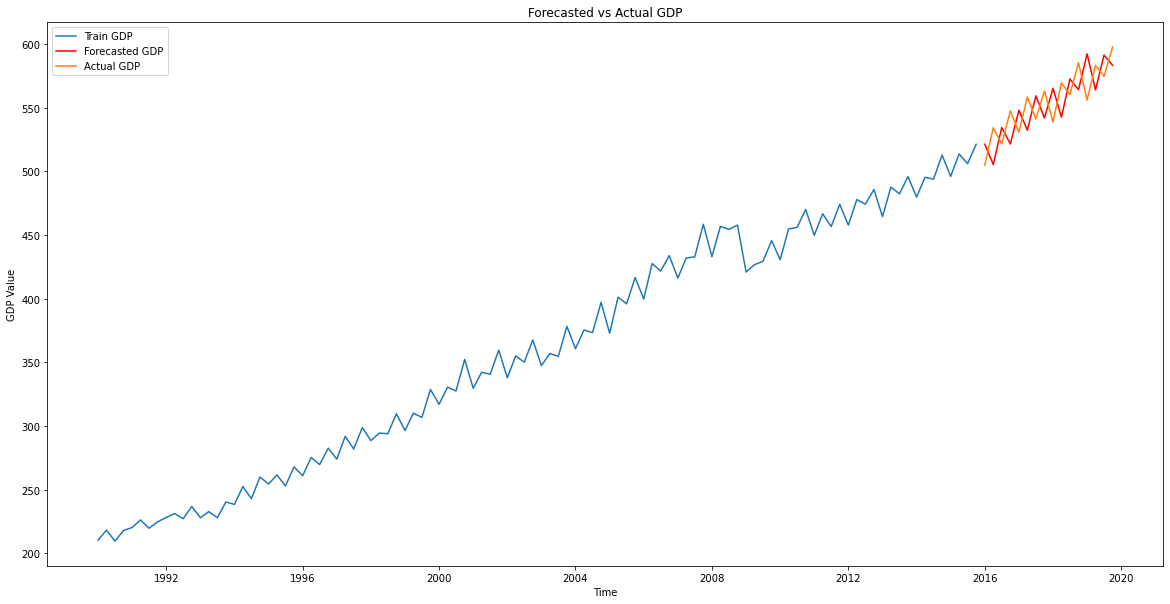

In [15]:
# Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'].to_numpy(), gdp_train['Value'].to_numpy(), label='Train GDP')
plt.plot(gdp_test['Time'].to_numpy(), y_preds, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'].to_numpy(), gdp_test['Value'].to_numpy(), label='Actual GDP')
plt.xlabel('Time')
plt.ylabel('GDP Value')
plt.title('Forecasted vs Actual GDP')
plt.legend(loc='upper left')
plt.show()



In [16]:
import os
import json

#Define the evaluation metric name for this model
metric_name = "One_UniVar_Pre_RNN"

# Create a dictionary with the MAPE value

# Get the current directory
current_dir = os.getcwd()

# Navigate to the directory where mape_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'mape_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the MAPE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the MAPE value to the dictionary with a corresponding key
data[metric_name] = mape_value

# Write the MAPE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)

# Create a dictionary with the RMSE value

# Navigate to the directory where rsme_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'rsme_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the RMSE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the RMSE value to the dictionary with a corresponding key
data[metric_name] = rmse_value

# Write the RMSE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)